# Distance map prediction

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from crops import make_batches

In [2]:
train_domains = np.loadtxt('../../data/our_input/train_domains.csv', dtype='O')

inp, out = {}, {}
for i in range(5):
    inp[train_domains[i]] = torch.load(f'../../data/our_input/tensors/{train_domains[i]}_X.pt')
    out[train_domains[i]] = torch.load(f'../../data/our_input/distance_maps/distance_maps32/{train_domains[i]}.pt')
    
    print(train_domains[i], inp[train_domains[i]].shape)

1zv1A00 torch.Size([569, 59, 59])
3t6pA02 torch.Size([569, 66, 66])
2ekfA01 torch.Size([569, 46, 46])
3q8gA01 torch.Size([569, 79, 79])
3hy5A01 torch.Size([569, 101, 101])


In [4]:
ex_i, ex_o = make_batches(inp['3q8gA01'], out['3q8gA01'])

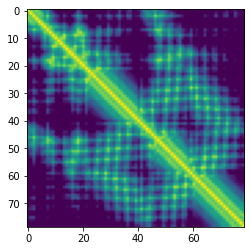

In [5]:
plt.imshow(out['3q8gA01'], 'viridis_r');

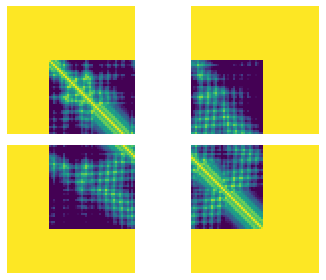

In [23]:
fig, ax = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        ax[i, j].imshow(ex_o[i * 2 + j], 'viridis_r');
        ax[i, j].axis('off')
fig.tight_layout()

In [13]:
np.nonzero(ex_o[0])

tensor([[27, 21],
        [27, 22],
        [27, 23],
        ...,
        [63, 61],
        [63, 62],
        [63, 63]])

In [6]:
def unpad_crop(crop, label):
    non_zero_ind = np.nonzero(label)
    
    if len(non_zero_ind) == 0:
        return crop
    else:
        i0, imax = torch.min(non_zero_ind[:, 0]), torch.max(non_zero_ind[:, 0])
        j0, jmax = torch.min(non_zero_ind[:, 1]), torch.max(non_zero_ind[:, 1])
        
        unpadded = torch.empty((imax - i0 + 1, jmax - j0 + 1))
        
        for (i, j) in non_zero_ind:
            unpadded[i - i0, j - j0] = crop[i, j]
    return unpadded

In [20]:
a = unpad_crop(ex_o[0], ex_o[0])

torch.Size([37, 43])
torch.Size([37, 36])
torch.Size([42, 43])
torch.Size([42, 36])


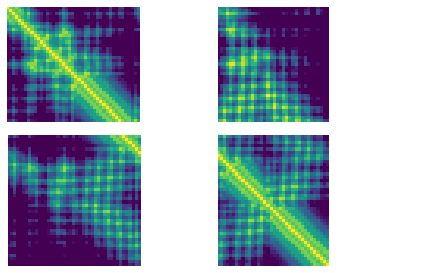

In [27]:
fig, ax = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        a = unpad_crop(ex_o[i * 2 + j], ex_o[i * 2 + j])
        ax[i, j].imshow(a, 'viridis_r');
        ax[i, j].axis('off')
        ax[i, j].set_xlim(0, 64)
        print(a.shape)
fig.tight_layout()

In [7]:
def predict_and_glue(model, domain, random_state=1):
    
    X = torch.load(f'../../data/our_input/tensors/{domain}_X.pt')
    Y = torch.load(f'../../data/our_input/distance_maps/distance_maps32/{domain}.pt')
    
    L = Y.shape[1]

    if L % 64 == 0 and random_state % 2 != 0:
        k = L // 64
    else:
        k = L // 64 + 1
    
    i, o = make_batches(X, Y, random_state=random_state)
    preds = model.predict(i)
    #preds = o
    
    dist_map = torch.empty((L, L), dtype=torch.long)
    
    i0 = 0
    for i in range(k):
        j0 = 0
        for j in range(k):
            unpadded = unpad_crop(preds[i * k + j], o[i * k + j])
            imax, jmax = unpadded.shape
            dist_map[i0:(i0 + imax), j0:(j0 + jmax)] = unpadded
            j0 += jmax
        i0 += imax
    return dist_map

In [8]:
def predict_distmap(model, domain, iterations=4):
    
    distmaps = torch.tensor([], dtype=torch.long)
    for i in range(iterations):
        pred = predict_and_glue(model, domain, random_state=1618+i)
        distmaps = torch.cat((distmaps, pred.view(1, pred.shape[0], pred.shape[0])))
    
    return torch.round(torch.mean(distmaps.to(torch.float), axis=0)).to(torch.long)

In [98]:
aa = predict_distmap('', '3q8gA01')

In [99]:
aa.shape

torch.Size([79, 79])

In [100]:
aa

tensor([[ 1,  7,  9,  ..., 31, 31, 31],
        [ 7,  1,  7,  ..., 29, 31, 31],
        [ 9,  7,  1,  ..., 30, 31, 31],
        ...,
        [31, 29, 30,  ...,  1,  6,  9],
        [31, 31, 31,  ...,  6,  1,  6],
        [31, 31, 31,  ...,  9,  6,  1]])

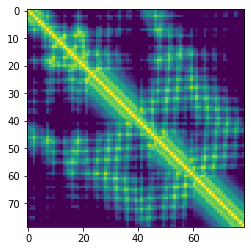

In [101]:
plt.imshow(aa, cmap='viridis_r');

In [72]:
for d in inp:
    pg = predict_and_glue('', d)
    print(torch.sum(pg != out[d]))

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


---

# Predictions in batches

The idea here is to predict every domain 8 times (since that is the size of the batch we used during training)

In [3]:
# open domain lengths
import pickle
with open('../../steps/domain_lengths.pkl', 'rb') as f:
    domain_lengths = pickle.load(f)

In [15]:
from ConvNet import ConvNet
convnet = ConvNet()
sd = torch.load('../../steps/convnet_results/model.pth', map_location=torch.device('cpu'))
convnet.load_state_dict(sd['model'])
# original saved file with DataParallel
# create new OrderedDict that does not contain `module.`

RuntimeError: Error(s) in loading state_dict for ConvNet:
	Missing key(s) in state_dict: "convOut.weight", "convOut.bias". 
	Unexpected key(s) in state_dict: "conv_dist.weight", "conv_dist.bias", "conv_aux0.weight", "conv_aux0.bias", "conv_aux_ij.weight", "conv_aux_ij.bias". 

## 1. Create Crops

In [11]:
def make_crops(domain):
    
    L = domain_lengths[domain]
    k = (L // 64 + 1) ** 2
    
    if L % 64 == 0:
        num_crops = 6 * k
        #k0 = k = (L // 64) ** 2  # if the random state is odd
    else:
        num_crops = 8 * k
    
    X = torch.load(f'../../data/our_input/tensors/{domain}_X.pt')
    Y = torch.load(f'../../data/our_input/distance_maps/distance_maps32/{domain}.pt')
    
    input_crops = torch.empty((num_crops, 569, 64, 64))
    output_crops = torch.empty((num_crops, 64, 64))
    
    if L % 64 == 0:
        s = 0
        for i in range(8):
            k_temp = (L // 64 + (1 - i % 2)) ** 2  # k if even, k0 if odd 
            input_crops[s:(s + k_temp)], output_crops[s:(s + k_temp)] = make_batches(X, Y, random_state=1618 + i)
            s += k_temp
    else:
        for i in range(8):
            input_crops[(k * i):(k * (i + 1))], output_crops[(k * i):(k * (i + 1))] = make_batches(X, Y, random_state=1618 + i)
        
    return input_crops, output_crops

## 2. Predict

In [12]:
def _predict_crops(model, in_crops, bins=32, device='cpu'):
    
    preds = torch.empty((in_crops.shape[0], bins, 64, 64))
    
    for i in range(in_crops.shape[0] // 8):
        batch_in = in_crops[(8 * i):(8 * (i + 1))]
        
        if device == 'cuda':
            batch_in = batch_in.to('cuda')
            preds[(8 * i):(8 * (i + 1))] = model.predict(batch_in)
            
            del batch_in, batch_out
            torch.cuda.empty_cache()
        else:
            preds[(8 * i):(8 * (i + 1))] = model.predict(batch_in)
    return preds

## 3. Unpad and Glue predicted crops

In [13]:
def unpad_crop(crop, label):
    non_zero_ind = np.nonzero(label)
    
    if len(non_zero_ind) == 0:
        return crop
    else:
        i0, imax = torch.min(non_zero_ind[:, 0]), torch.max(non_zero_ind[:, 0])
        j0, jmax = torch.min(non_zero_ind[:, 1]), torch.max(non_zero_ind[:, 1])
        
        unpadded = torch.empty((32, imax - i0 + 1, jmax - j0 + 1))
        
        for (i, j) in non_zero_ind:
            unpadded[:, i - i0, j - j0] = crop[:, i, j]
    return unpadded

In [14]:
def _unpad_and_glue(preds, out_crops, L):
    """Assumes crops are only from 1 domain and only 1 copy
    
    Returns crops that are transformed to probability distributions
    """
    
    distogram = torch.empty((32, L, L), dtype=torch.float32)
    k = int(np.sqrt(len(preds)))
    
    i0 = 0
    for i in range(k):
        j0 = 0
        for j in range(k):
            unpadded = unpad_crop(preds[i * k + j], out_crops[i * k + j])
            width, height = unpadded.shape[1:]
            distogram[:, i0:(i0 + width), j0:(j0 + height)] = torch.exp(unpadded)  # log(softmax) -> softmax
            j0 += height
        i0 += width
            
    return distogram

## Put it all together

In [8]:
from crops import make_crop_indices

In [10]:
make_crop_indices(128, random_state=0)

array([[(0, 0), (32, 32), 'topleft'],
       [(0, 32), (32, 96), 'top'],
       [(0, 96), (32, 128), 'topright'],
       [(32, 0), (96, 32), 'left'],
       [(32, 32), (96, 96), None],
       [(32, 96), (96, 128), 'right'],
       [(96, 0), (128, 32), 'bottomleft'],
       [(96, 32), (128, 96), 'bottom'],
       [(96, 96), (128, 128), 'bottomright']], dtype=object)

In [15]:
def _predict(model, domain):
    
    L = domain_lengths[domain]
    distograms = torch.empty((8, 32, L, L))
    
    i, o = make_crops(domain)
    p = _predict_crops(model, i)
    
    if L % 64 == 0:
        # !!!This assumes that first random state in make_crops was even !!!
        s = 0
        for i in range(8):
            if i % 2 == 1:
                k = (L // 64) ** 2
            else:
                k = (L // 64 + 1) ** 2
            
            distograms[i] = _unpad_and_glue(p[s:(s + k)], o[s:(s + k)], L)
            s += k
    else:
        k = (L // 64 + 1) ** 2
        for i in range(8):
            distograms[i] = _unpad_and_glue(p[(i * k):((i + 1) * k)], o[(i * k):((i + 1) * k)], L)
    
    distogram = torch.mean(distograms, dim=0)
        
    return (distogram / torch.sum(distogram, dim=0)).detach()  # normalize histograms

In [48]:
x = [0]
x.extend([2 + 20/30 * i for i in range(31)])
np.array(x)

array([ 0.        ,  2.        ,  2.66666667,  3.33333333,  4.        ,
        4.66666667,  5.33333333,  6.        ,  6.66666667,  7.33333333,
        8.        ,  8.66666667,  9.33333333, 10.        , 10.66666667,
       11.33333333, 12.        , 12.66666667, 13.33333333, 14.        ,
       14.66666667, 15.33333333, 16.        , 16.66666667, 17.33333333,
       18.        , 18.66666667, 19.33333333, 20.        , 20.66666667,
       21.33333333, 22.        ])

In [55]:
def calc_mean(distogram, bins=32):
    """
    Mean of a distribution: sum(x * p(x))
    """
    x = [0]
    x.extend([2 + 20/30 * i for i in range(bins - 1)])
    x = torch.tensor(x)
    
    L = distogram.shape[1]
    
    mean_distmap = torch.empty((L, L))
    
    for i in range(L):
        for j in range(L):
            mean_distmap[i, j] = torch.sum(distogram[:, i, j] * x)
    return mean_distmap    

In [39]:
def predict_distmap(model, domain, op='argmax'):
    
    if op == 'argmax' or 'mode':
        distogram = _predict(model, domain)
        return torch.argmax(distogram, dim=0)
    elif op == 'mean' or 'average':
        distogram = _predict(model, domain)
        return calc_mean(distogram)
    else:
        return 'Unknown operation'

In [17]:
i, o = make_crops('1zv1A00')
#i, o = make_crops('3q8gA01')

In [126]:
i.shape

torch.Size([8, 569, 64, 64])

In [18]:
p = _predict_crops(convnet, i)

In [19]:
p.shape

torch.Size([8, 32, 64, 64])

In [20]:
a = _unpad_and_glue(p[:1], o[:1], 59)
#a = _unpad_and_glue(p[:4], o[:4], 79)

In [21]:
ad = torch.argmax(a, dim=0)

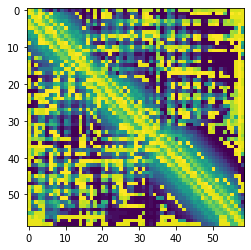

In [22]:
plt.imshow(ad, cmap='viridis_r')

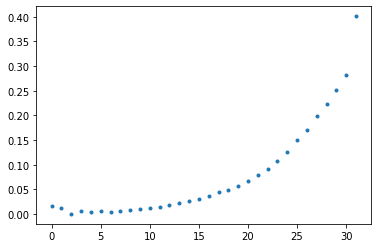

In [108]:
plt.plot(np.arange(32), a[:, 15, 50].data.numpy(), '.')

In [141]:
pp = _predict(convnet, '3q8gA01')

In [142]:
pp.shape

torch.Size([32, 79, 79])

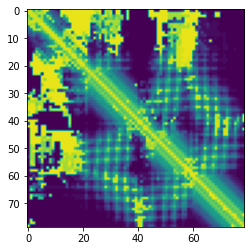

In [143]:
ad = torch.argmax(pp, dim=0)
plt.imshow(ad, cmap='viridis_r')

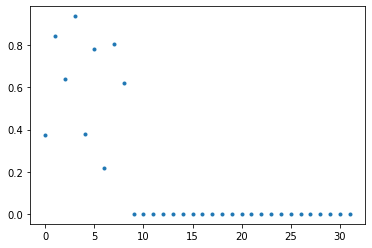

In [153]:
plt.plot(np.arange(32), pp[:, 0, 1].data.numpy(), '.')

In [151]:
torch.sum(pp[:, 0, 0])

tensor(1.3046, grad_fn=<SumBackward0>)

In [154]:
summed_bins = torch.sum(pp, dim=0)

In [156]:
pp_n = pp / summed_bins

In [159]:
pp[:, 1, 15] / torch.sum(pp[:, 1, 15])

tensor([5.9265e-09, 6.3055e-02, 3.3935e-02, 3.1113e-02, 3.5344e-02, 3.4405e-02,
        3.3639e-02, 3.3755e-02, 3.2276e-02, 3.1808e-02, 3.1794e-02, 3.2217e-02,
        3.0527e-02, 3.6545e-02, 3.8384e-02, 3.7251e-02, 3.5835e-02, 3.4041e-02,
        3.2698e-02, 3.1567e-02, 2.7937e-02, 2.6920e-02, 2.7618e-02, 2.7477e-02,
        2.7709e-02, 2.8023e-02, 2.8859e-02, 2.7415e-02, 2.6897e-02, 2.7854e-02,
        3.0079e-02, 2.3021e-02], grad_fn=<DivBackward0>)

In [160]:
pp_n[:, 1, 15]

tensor([5.9265e-09, 6.3055e-02, 3.3935e-02, 3.1113e-02, 3.5344e-02, 3.4405e-02,
        3.3639e-02, 3.3755e-02, 3.2276e-02, 3.1808e-02, 3.1794e-02, 3.2217e-02,
        3.0527e-02, 3.6545e-02, 3.8384e-02, 3.7251e-02, 3.5835e-02, 3.4041e-02,
        3.2698e-02, 3.1567e-02, 2.7937e-02, 2.6920e-02, 2.7618e-02, 2.7477e-02,
        2.7709e-02, 2.8023e-02, 2.8859e-02, 2.7415e-02, 2.6897e-02, 2.7854e-02,
        3.0079e-02, 2.3021e-02], grad_fn=<SelectBackward>)

In [162]:
torch.sum(pp_n[:, 1, 15])

tensor(1.0000, grad_fn=<SumBackward0>)

In [3]:
from predict import predict

In [23]:
p = _predict(convnet, '1zv1A00')

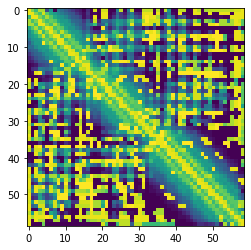

In [24]:
ad = torch.argmax(p, dim=0)
plt.imshow(ad, cmap='viridis_r')

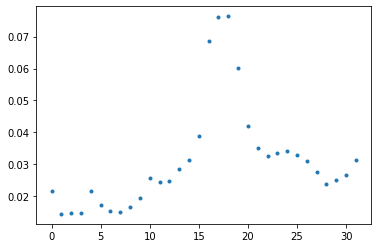

In [13]:
plt.plot(np.arange(32), p[:, 1, 9].data.numpy(), '.')

In [28]:
for d in domain_lengths:
    if domain_lengths[d] == 64:
        print(d, domain_lengths[d])
        break

4nb5B02 64


In [25]:
pp = _predict(convnet, '4nb5B02')

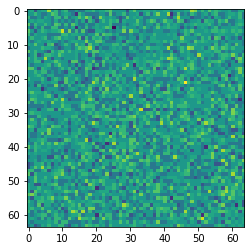

In [37]:
ad = torch.mean(pp.detach(), dim=0)
plt.imshow(ad, cmap='viridis_r')

In [57]:
aaa= calc_mean(pp.detach())

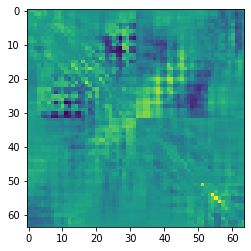

In [58]:
plt.imshow(aaa, cmap ='viridis_r')

---

# PREDICT VALIDATION AND TEST SET

In [1]:
import numpy as np
import torch
from AlphaFold import AlphaFold
from Inception_aux import Inception_aux
import pickle
import matplotlib.pyplot as plt
import os

In [2]:
validation = np.loadtxt('../../data/our_input/validation_domains.csv', dtype='O')
test = np.loadtxt('../../data/our_input/test_domains.csv', dtype='O')

In [11]:
with open('../../steps/predicted_outputs/validation/inception/1z6mA02_out.pkl', 'rb') as f:
    d = pickle.load(f)

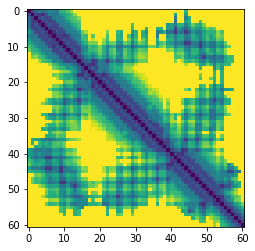

In [14]:
plt.imshow(torch.argmax(d['distogram'], dim = 0))

### Validation domains

In [19]:
for d in validation:
    with open(f'../../steps/predicted_outputs/scripts/{d}.sh', 'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH --mem=4g\n')
        f.write('#SBATCH -t 60\n')
        f.write(f'#SBATCH -o ../../steps/garbage/{d}-%j.out\n')
        f.write(f'python3 predict_domains.py -d {d} -o ../../steps/predicted_outputs/validation')
    os.system(f'sbatch ../../steps/predicted_outputs/scripts/{d}.sh')

### Test domains

In [20]:
for d in test:
    with open(f'../../steps/predicted_outputs/scripts/{d}.sh', 'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH --mem=4g\n')
        f.write('#SBATCH -t 60\n')
        f.write(f'#SBATCH -o ../../steps/garbage/{d}-%j.out\n')
        f.write(f'python3 predict_domains.py -d {d} -o ../../steps/predicted_outputs/test')
    os.system(f'sbatch ../../steps/predicted_outputs/scripts/{d}.sh')

### Domains that were not predicted due to low memory

In [3]:
ls ../../steps/predicted_outputs/validation/alphafold/ -1 | wc -l

995


In [4]:
ls ../../steps/predicted_outputs/validation/inception/ -1 | wc -l

988


In [5]:
ls ../../steps/predicted_outputs/test/alphafold/ -1 | wc -l

500


In [7]:
ls ../../steps/predicted_outputs/test/inception/ -1 | wc -l

498


#### both alphafold and inception

In [3]:
valalpha = np.array([i.split('_')[0] for i in os.listdir('../../steps/predicted_outputs/validation/alphafold/')])

In [6]:
dif = np.setdiff1d(validation, valalpha)

In [7]:
dif

array(['2ivfA00'], dtype=object)

In [19]:
dif

array(['1v25A01', '2ivfA00', '3c5eA01', '4r0mB01', '5bsrA01'],
      dtype=object)

In [27]:
for d in dif:
    with open(f'../../steps/predicted_outputs/scripts/{d}.sh', 'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH --mem=16g\n')
        f.write('#SBATCH -t 600\n')
        f.write(f'#SBATCH -o ../../steps/garbage/{d}-%j.out\n')
        f.write(f'python3 predict_domains.py -d {d} -o ../../steps/predicted_outputs/validation')
    os.system(f'sbatch ../../steps/predicted_outputs/scripts/{d}.sh')

#### only validation set inception

In [23]:
valinc = np.array([i.split('_')[0] for i in os.listdir('../../steps/predicted_outputs/validation/inception/')])

In [26]:
difinc_v = np.setdiff1d(valalpha, valinc)

In [28]:
difinc_v

array(['1j93A00', '2ejaA00', '2gj4A02', '2y27B01', '3rpdA00', '4ay7A00',
       '4zr8B00'], dtype='<U7')

In [29]:
for d in difinc_v:
    with open(f'../../steps/predicted_outputs/scripts/{d}.sh', 'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH --mem=16g\n')
        f.write('#SBATCH -t 600\n')
        f.write(f'#SBATCH -o ../../steps/garbage/{d}-%j.out\n')
        f.write(f'python3 predict_domains.py -d {d} -o ../../steps/predicted_outputs/validation')
    os.system(f'sbatch ../../steps/predicted_outputs/scripts/{d}.sh')

In [30]:
testinc = np.array([i.split('_')[0] for i in os.listdir('../../steps/predicted_outputs/test/inception/')])

In [32]:
tdif = np.setdiff1d(test, testinc)

In [33]:
tdif

array(['1iq8A01', '4d6qA00'], dtype=object)

In [34]:
for d in tdif:
    with open(f'../../steps/predicted_outputs/scripts/{d}.sh', 'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH --mem=16g\n')
        f.write('#SBATCH -t 600\n')
        f.write(f'#SBATCH -o ../../steps/garbage/{d}-%j.out\n')
        f.write(f'python3 predict_domains.py -d {d} -o ../../steps/predicted_outputs/test')
    os.system(f'sbatch ../../steps/predicted_outputs/scripts/{d}.sh')

In [8]:
for d in ['2ivfA00']:
    with open(f'../../steps/predicted_outputs/scripts/{d}.sh', 'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH --mem=64g\n')
        f.write('#SBATCH -t 600\n')
        f.write(f'#SBATCH -o ../../steps/garbage/{d}-%j.out\n')
        f.write(f'python3 predict_domains.py -d {d} -o ../../steps/predicted_outputs/validation')
    os.system(f'sbatch ../../steps/predicted_outputs/scripts/{d}.sh')